# <center>  The Battle of neighborhoods

## Business understanding

### Kuala lumpur is the capital of malaysia and contains over 18.1 lakh of population. 
### Let's see the venues which is present in the city and analyse the shops present and find which place ould be the better one to open an particular kind of shop.

In [1]:
#import required libraries
from geopy.geocoders import Nominatim
import geocoder
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import folium
import pandas as pd
import re
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
import pyproj
import numpy as np

## Data requirements
### There are many sites are available to get the open source data. i am using one of the wikipedia page to work on this page (https://en.wikipedia.org/wiki/Category:Suburbs_in_Kuala_Lumpur)

## Data collection
### I am using BeautifulSoup to scrap the data from the mentioned url and take the fields which I will be working on.

In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Suburbs_in_Kuala_Lumpur").text
soup = BeautifulSoup(data, 'html.parser')

neighborhoodList = []
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)
    
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})

kl_df.head()    

,Neighborhood
0,Alam Damai
1,"Ampang, Kuala Lumpur"
2,Bandar Menjalara
3,Bandar Sri Permaisuri
4,Bandar Tasik Selatan


Our data does not have co-ordinates. so we need to download it using geocoder

In [3]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Kuala Lumpur, Malaysia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [4]:
# iterate to get the latitude and longitude
coords = [ get_latlng(neighborhood) for neighborhood in kl_df["Neighborhood"].tolist() ]

In [5]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [6]:
kl_df['Latitude'] = df_coords['Latitude']
kl_df['Longitude'] = df_coords['Longitude']

In [7]:
kl_df.head()

,Neighborhood,Latitude,Longitude
0,Alam Damai,3.057690,101.743880
1,"Ampang, Kuala Lumpur",3.148499,101.696728
2,Bandar Menjalara,3.190350,101.625450
3,Bandar Sri Permaisuri,3.103910,101.712260
4,Bandar Tasik Selatan,3.072750,101.714610


## Data Visualization
### For now we have scraped the data and lets visualize the data we scraped using folium

In [8]:
address = 'kuala lumpur, malaysia'

geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of kuala lumpur, malaysia are {}, {}.'.format(latitude, longitude))

The geographical coordinate of kuala lumpur, malaysia are 3.1516964, 101.6942371.


In [9]:
kl_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(kl_map)  
    
kl_map

### Folium

In [10]:
CLIENT_ID =  '' # your Foursquare ID
CLIENT_SECRET =  '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT =  100 # A default Foursquare API limit value

### Analyzing the neighborhood

In [11]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
kl_venues = getNearbyVenues(names=kl_df['Neighborhood'],
                                   latitudes=kl_df['Latitude'],
                                   longitudes=kl_df['Longitude']
                                  )
kl_venues.head()

Alam Damai
Ampang, Kuala Lumpur
Bandar Menjalara
Bandar Sri Permaisuri
Bandar Tasik Selatan
Bandar Tun Razak
Bangsar
Bangsar Park
Bangsar South
Batu 11 Cheras
Batu, Kuala Lumpur
Brickfields
Bukit Bintang
Bukit Jalil
Bukit Kiara
Bukit Nanas
Bukit Petaling
Bukit Tunku
Cheras, Kuala Lumpur
Chow Kit
Damansara Heights
Damansara Town Centre
Dang Wangi
Desa Petaling
Federal Hill, Kuala Lumpur
Happy Garden
Jalan Cochrane, Kuala Lumpur
Jinjang
Kampung Baru, Kuala Lumpur
Kampung Datuk Keramat
Kampung Kasipillay
Kampung Padang Balang
Kepong
Kepong Baru
KL Eco City
Kuchai Lama
Lembah Pantai
Maluri
Medan Tuanku
Miharja
Mont Kiara
Pantai Dalam
Pudu, Kuala Lumpur
Putrajaya
Salak South
Segambut
Semarak
Sentul, Kuala Lumpur
Setapak
Setiawangsa
Shamelin
Sri Hartamas
Sri Petaling
Sungai Besi
Taman Bukit Maluri
Taman Connaught
Taman Desa
Taman Duta
Taman Ibukota
Taman Len Seng
Taman Melati
Taman Midah
Taman OUG
Taman P. Ramlee
Taman Sri Sinar
Taman Taynton View
Taman Tun Dr Ismail
Taman U-Thant
Taman Wahy

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alam Damai,3.05769,101.74388,628火焰鑫茶室,3.058442,101.747947,Chinese Restaurant
1,Alam Damai,3.05769,101.74388,Restaurant Sweetland 甜园美食中心,3.057495,101.747725,Chinese Restaurant
2,Alam Damai,3.05769,101.74388,Machi Noodle 妈子面,3.057695,101.746635,Noodle House
3,Alam Damai,3.05769,101.74388,Pasar Pagi Alam Damai (Alam Damai Morning Market),3.056932,101.745458,Farmers Market
4,Alam Damai,3.05769,101.74388,SUSHI MENTAI,3.057821,101.748145,Japanese Restaurant


## Data understanding
### Now we need to understand the data we have. So I am using various techniques as below.

In [13]:
kl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alam Damai,15,15,15,15,15,15
"Ampang, Kuala Lumpur",99,99,99,99,99,99
Bandar Menjalara,53,53,53,53,53,53
Bandar Sri Permaisuri,33,33,33,33,33,33
Bandar Tasik Selatan,35,35,35,35,35,35
...,...,...,...,...,...,...
Taman Tun Dr Ismail,57,57,57,57,57,57
Taman U-Thant,15,15,15,15,15,15
Taman Wahyu,18,18,18,18,18,18


In [14]:
kl_onehot = pd.get_dummies(kl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['Neighborhood'] = kl_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

kl_onehot.head()

,Yoga Studio,African Restaurant,Airport,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
print('There are {} uniques categories.'.format(len(kl_venues['Venue Category'].unique())))

There are 265 uniques categories.


In [16]:
print('There are {}  categories.'.format(kl_venues['Venue Category'].unique()))

There are ['Chinese Restaurant' 'Noodle House' 'Farmers Market'
 'Japanese Restaurant' 'Breakfast Spot' 'Dim Sum Restaurant' 'Food Truck'
 'Asian Restaurant' 'Padangnese Restaurant' 'Fast Food Restaurant'
 'Pet Store' 'Café' 'Exhibit' 'Hostel' 'South Indian Restaurant'
 'Indian Restaurant' 'Chettinad Restaurant' 'Dessert Shop' 'Restaurant'
 'Gym' 'Monument / Landmark' 'Athletics & Sports' 'Coffee Shop' 'Theater'
 'Convenience Store' 'Juice Bar' 'Bed & Breakfast' 'Cupcake Shop'
 'Wine Bar' 'Thai Restaurant' 'Flower Shop' 'Park' 'Bakery'
 'Deli / Bodega' 'Other Nightlife' 'Bar' 'Food Court'
 'Vegetarian / Vegan Restaurant' 'Food Stand' 'Hotel' 'Malay Restaurant'
 'Bubble Tea Shop' 'Filipino Restaurant' 'Art Gallery'
 'Fried Chicken Joint' 'Sandwich Place' 'Government Building'
 'Department Store' 'Club House' 'Dog Run' 'Tailor Shop' 'Plaza'
 'Sporting Goods Shop' 'American Restaurant' 'Ice Cream Shop'
 'Pizza Place' 'Spanish Restaurant' 'Korean Restaurant' 'Bistro'
 'Hotpot Restaurant' '

In [17]:
kl_grouped = kl_onehot.groupby('Neighborhood').mean().reset_index()
kl_grouped.head()

,Neighborhood,Yoga Studio,African Restaurant,Airport,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yakitori Restaurant
0,Alam Damai,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,"Ampang, Kuala Lumpur",0.0,0.000000,0.0,0.0,0.010101,0.0,0.0,0.020202,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.0,0.0,0.0
2,Bandar Menjalara,0.0,0.018868,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Bandar Sri Permaisuri,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Bandar Tasik Selatan,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [18]:
num_top_venues = 5

for hood in kl_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kl_grouped[kl_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alam Damai----
                 venue  freq
0   Chinese Restaurant  0.20
1       Breakfast Spot  0.13
2         Noodle House  0.07
3  Japanese Restaurant  0.07
4           Food Truck  0.07


----Ampang, Kuala Lumpur----
               venue  freq
0  Indian Restaurant  0.12
1  Convenience Store  0.07
2   Asian Restaurant  0.07
3               Café  0.05
4        Coffee Shop  0.04


----Bandar Menjalara----
                venue  freq
0  Chinese Restaurant  0.11
1        Noodle House  0.08
2         Coffee Shop  0.06
3                Café  0.06
4    Malay Restaurant  0.06


----Bandar Sri Permaisuri----
                   venue  freq
0       Malay Restaurant  0.12
1  Indonesian Restaurant  0.09
2           Burger Joint  0.06
3            Pizza Place  0.06
4                   Café  0.06


----Bandar Tasik Selatan----
              venue  freq
0   Thai Restaurant  0.11
1      Burger Joint  0.09
2              Café  0.09
3        Food Court  0.06
4  Asian Restaurant  0.06


----Bandar T

4    Asian Restaurant  0.05


----Putrajaya----
                venue  freq
0    Asian Restaurant  0.11
1  Chinese Restaurant  0.09
2                Café  0.06
3               Hotel  0.06
4      Sandwich Place  0.06


----Salak South----
                venue  freq
0  Chinese Restaurant  0.38
1   Indian Restaurant  0.10
2         Karaoke Bar  0.05
3    Malay Restaurant  0.05
4        Tennis Court  0.05


----Segambut----
               venue  freq
0   Department Store  0.14
1  Indian Restaurant  0.14
2         Restaurant  0.14
3       Soccer Field  0.14
4        Gas Station  0.14


----Semarak----
              venue  freq
0  Asian Restaurant  0.14
1     Movie Theater  0.14
2     Track Stadium  0.14
3              Park  0.14
4              Pool  0.14


----Sentul, Kuala Lumpur----
                venue  freq
0   Indian Restaurant  0.29
1  Chinese Restaurant  0.18
2     Motorcycle Shop  0.18
3    Asian Restaurant  0.06
4         Coffee Shop  0.06


----Setapak----
                      

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kl_grouped['Neighborhood']

for ind in np.arange(kl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alam Damai,Chinese Restaurant,Breakfast Spot,Asian Restaurant,Farmers Market,Dim Sum Restaurant,Fast Food Restaurant,Pet Store,Food Truck,Padangnese Restaurant,Noodle House
1,"Ampang, Kuala Lumpur",Indian Restaurant,Convenience Store,Asian Restaurant,Café,Coffee Shop,Hotel,Chinese Restaurant,South Indian Restaurant,Bed & Breakfast,Restaurant
2,Bandar Menjalara,Chinese Restaurant,Noodle House,Malay Restaurant,Café,Coffee Shop,Pizza Place,Japanese Restaurant,Park,Convenience Store,Asian Restaurant
3,Bandar Sri Permaisuri,Malay Restaurant,Indonesian Restaurant,Café,Burger Joint,Chinese Restaurant,Pizza Place,Bistro,Cosmetics Shop,Convenience Store,Gym
4,Bandar Tasik Selatan,Thai Restaurant,Burger Joint,Café,Food Court,Asian Restaurant,Seafood Restaurant,Indonesian Restaurant,Malay Restaurant,Middle Eastern Restaurant,Gym


## Data Analytics
### There are many techniques are available in Data science field. For my project, I am going to use clustering. Particulary, I am going to use K-Means clustering. So, I need to how many cluster could be better for my data. That analysis I am doing here.

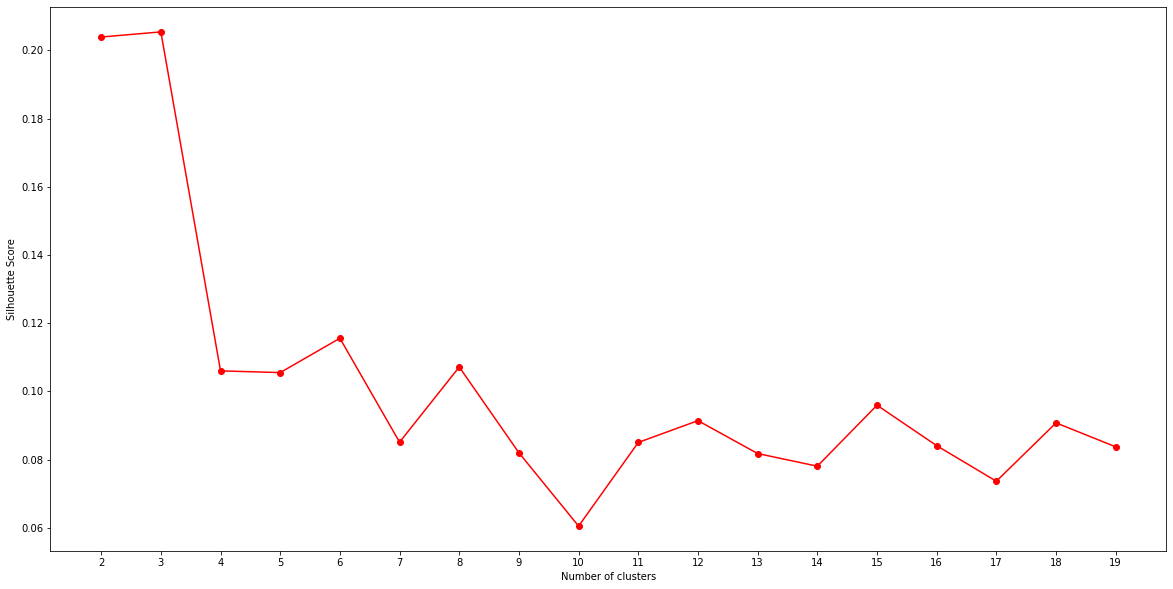

In [21]:
kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

max_score = 20
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kl_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(kl_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

## Model evaluation
### Now we have cleaned data and found all the pre-requisite to model our data

From the graph it looks cluster 3 could be the better one. 

so, let's use number of clusters as 3

In [22]:
kclusters = 3

kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1])

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_merged = kl_df

# merge chn_grouped with chn_data to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kl_merged.head() # check the last columns

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alam Damai,3.057690,101.743880,0,Chinese Restaurant,Breakfast Spot,Asian Restaurant,Farmers Market,Dim Sum Restaurant,Fast Food Restaurant,Pet Store,Food Truck,Padangnese Restaurant,Noodle House
1,"Ampang, Kuala Lumpur",3.148499,101.696728,1,Indian Restaurant,Convenience Store,Asian Restaurant,Café,Coffee Shop,Hotel,Chinese Restaurant,South Indian Restaurant,Bed & Breakfast,Restaurant
2,Bandar Menjalara,3.190350,101.625450,1,Chinese Restaurant,Noodle House,Malay Restaurant,Café,Coffee Shop,Pizza Place,Japanese Restaurant,Park,Convenience Store,Asian Restaurant
3,Bandar Sri Permaisuri,3.103910,101.712260,1,Malay Restaurant,Indonesian Restaurant,Café,Burger Joint,Chinese Restaurant,Pizza Place,Bistro,Cosmetics Shop,Convenience Store,Gym
4,Bandar Tasik Selatan,3.072750,101.714610,1,Thai Restaurant,Burger Joint,Café,Food Court,Asian Restaurant,Seafood Restaurant,Indonesian Restaurant,Malay Restaurant,Middle Eastern Restaurant,Gym


In [24]:
kl_merged.dropna(inplace=True)
kl_merged.astype({'Cluster Labels': 'int32'}).dtypes

Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [25]:
df = kl_merged.copy([['Cluster Labels', 'Neighborhood']])
a = df.groupby(['Cluster Labels'])['Neighborhood'].value_counts()
print(a)

Cluster Labels  Neighborhood              
0               Alam Damai                    1
                Jinjang                       1
                Kampung Kasipillay            1
                Kepong                        1
                Kepong Baru                   1
                                             ..
1               Wangsa Maju                   1
2               Bukit Petaling                1
                Kampung Baru, Kuala Lumpur    1
                Kampung Datuk Keramat         1
                Pantai Dalam                  1
Name: Neighborhood, Length: 71, dtype: int64


In [26]:

#Visualize the cluster
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

In [27]:

cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Chinese Restaurant    16
Asian Restaurant      12
Malay Restaurant      10
Noodle House           8
Café                   7
Restaurant             6
Indian Restaurant      6
Convenience Store      6
Coffee Shop            5
Dessert Shop           5
dtype: int64


In [28]:

cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Café                  37
Malay Restaurant      27
Chinese Restaurant    26
Coffee Shop           23
Convenience Store     20
Asian Restaurant      19
Hotel                 15
Restaurant            15
Indian Restaurant     12
Food Court            12
dtype: int64


In [29]:

cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 2, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Malay Restaurant         4
Thai Restaurant          3
Indonesian Restaurant    2
Restaurant               2
Asian Restaurant         2
Café                     2
Seafood Restaurant       2
Breakfast Spot           2
Gas Station              1
Italian Restaurant       1
dtype: int64


## Result analysis

### From the data we analyzed we can conclude as follows.
### COFFEE SHOP :  cluster 0 is having minimum number of coffee shops, cluster 1 have many coffee shop and cluster 2 does not have any coffee shops. So a person wants to open a coffee shop, either the venues in cluster 0 or cluster2 could be the better choice

### RESTAURANT : cluster 0 have 6 restaurant and cluster 1 have 15 restaurant. while in cluster 2 have only 2 restaurant in that area. So the regions in cluster 0 or cluter 2 could be the better option

In [30]:
kl_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(kl_clusters_map)
       
kl_clusters_map